In [1]:
import pandas as pd
import re
from itertools import chain,cycle, islice
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML, display_html

In [2]:
# Do not truncate column content and show all columns
pd.set_option('display.max_colwidth', None)

# Update output cell format to display mutliple objects (dataframes)
# https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h4>{title}</h4>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [3]:
prefix = '../../data/'
filePaths = {
    "reviews": prefix + 'yelp_academic_dataset_review.json',
    "businesses": prefix + 'yelp_academic_dataset_business.json',
    "checkins": prefix + 'yelp_academic_dataset_checkin.json',
    "tips": prefix + 'yelp_academic_dataset_tip.json',
    "users": prefix + 'yelp_academic_dataset_user.json'
}

# Filter Restaurant Businesses in Las Vegas

---

### Problem Description:
* The dataset ```yelp_academic_dataset_business.json``` has many business categories unrelated to food or restaurants.
* Identify and remove unrelated business categories from our dataset.

### Business Categories Documentation:

* The yelp developer documentation has a businesses [category list](https://www.yelp.com/developers/documentation/v3/category_list). 


* The category```Restaurant (restaurant)``` sub-divides into cuisine types, e.g.: 
    * Soul Food
    * Tapas
    * ...


* The category```Food (food)``` sub-divides into food vendors, e.g.:
    * Gelato
    * Food Trucks
    * ...
    

* Filter businesses that do not contain 'Food' or 'Restaurant' using regular expressions.

### Solution: Filter by category 'Restaurants' and 'Food'

In [4]:
# Create a dataframe containing all business categories
dfBusiness = pd.read_json(filePaths["businesses"], lines=True)

# Filter the original dataframe categories using a bool mask for 'Restaurants' or 'Food' in 'Las Vegas'
def restaurantCategories():
    restaurants = dfBusiness[
            (dfBusiness['categories'].str.contains('Restaurants')==True) | 
            (dfBusiness['categories'].str.contains('Food')==True)        &
            (dfBusiness['city'] == 'Las Vegas')
    ]
    return restaurants

# Filter businesses by restaurant and food
restaurants = restaurantCategories()
display_side_by_side(restaurants.categories.head(n=5).to_frame())

,categories
8,"Ethnic Food, Food Trucks, Specialty Food, Imported Food, Argentine, Food, Restaurants, Empanadas"
20,"Food, Restaurants, Grocery, Middle Eastern"
24,"Restaurants, Cheesesteaks, Poutineries"
25,"Japanese, Fast Food, Food Court, Restaurants"
30,"Persian/Iranian, Turkish, Middle Eastern, Restaurants, Kebab"


# Remove False Positive Restaurant Categories
---

### Problem Description:

* There exist business categories tagged as 'Restaurant' or 'Food' that are unrelated to Restaurants or Food

In [5]:
# Explode takes column that contains list values, and expand into multiple rows
dfExploded = restaurants.assign(categories = restaurants.categories.str.split(', ')).explode('categories')
dfCategoryCount = dfExploded.categories.value_counts().reset_index()
dfCategoryCount.columns = ['categories', 'count']

# Inspect the top and bottom categories
topCategories = dfCategoryCount.head(5)
bottomCategories = dfCategoryCount.tail(5)
display_side_by_side(
    topCategories, 
    bottomCategories, 
    titles=[f'Top {len(topCategories)} Restaurant Categories',f'Bottom {len(bottomCategories)} Restaurant Categories']
)

,categories,count
0,Restaurants,63944
1,Food,18494
2,Nightlife,9500
3,Bars,9080
4,Fast Food,8106
,categories,count
849,Drive-Thru Bars,1
850,Recording & Rehearsal Studios,1
851,Czech/Slovakian,1
852,Solar Installation,1


### Solution: Use apriori pruning to identify frequent restaurant categories

In [33]:
# Apriori implementation: https://github.com.rasbt/mlktend
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

# (1) Create lists of categories associated with business
restaurantCategoryList = restaurants.categories.str.split(', ').to_list()

# (2) Encode category lists for each restaurant as boolean arrays
te = TransactionEncoder()
categoryBoolArray = te.fit(restaurantCategoryList).transform(restaurantCategoryList)
categoryBoolDf = pd.DataFrame(categoryBoolArray, columns=te.columns_)

# (3) Use the apriori algorithm to find frequent business associations
MinSup = 0.10
aprioriItemsets = apriori(categoryBoolDf, min_support=MinSup, use_colnames=True)

# Display results
display_side_by_side(
    dfCategoryCount.head(20),
    aprioriItemsets, 
    titles=[f'<br><br>Top 20 Restaurant Categories<br><br>',
            f'Frequently Associated Restaurant Categories<br><br>Min. Support = {MinSup * 100}%<br><br>']
)

,categories,count
0,Restaurants,63944
1,Food,18494
2,Nightlife,9500
3,Bars,9080
4,Fast Food,8106
5,Sandwiches,8064
6,American (Traditional),7596
7,Pizza,7302
8,Breakfast & Brunch,6225
9,Burgers,6107


---

## Export to JSON

* Apply the restaurant filter to all datapoints in ```yelp_academic_dataset_business.json``` then export the processed data as a JSON 

In [12]:
# Export to JSON
restaurantsTrimmed.to_json(r'yelp_academic_dataset_restaurants.json')

## Summary:
    
* According to the Yelp developer documentation, regular expressions should be sufficient to remove unrelated business categories from our dataset.

* If our data set were not structured and well documented, we would likely need to consider a classification technique for businesses such as **Named Entiy Recognition (NER)**.


***
# Users json

## Data Pre-Processing: User Features and Users

---

## Problem Description:
* Remove redundant attributes through correlation analysis
* Normalize user attributes

## Reduce User attributes

In [13]:
userReader = pd.read_json(
    filePaths["users"], 
    lines=True,
    chunksize=100000 # Dataframe size
)

### Correlation Analysis on attributes (Pearson correlation coefficient)

In [14]:
for df in itertools.islice(userReader, 1):
    df = df.filter(items=['useful', 'funny', 'cool', 'fans',
                          'compliment_hot', 'compliment_more', 'compliment_profile', 'compliment_cute', 
                          'compliment_list', 'compliment_note','compliment_plain','compliment_cool', 
                          'compliment_funny','compliment_writer','compliment_photos'])

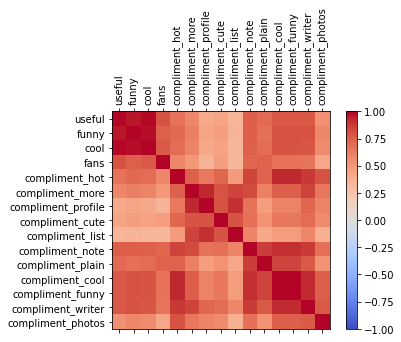

None

,useful,funny,cool,fans,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
useful,1.000000,0.964429,0.990598,0.800100,0.676497,0.590853,0.412548,0.438856,0.344067,0.750283,0.703319,0.775660,0.775660,0.778985,0.541254
funny,0.964429,1.000000,0.979204,0.749508,0.715929,0.618694,0.440731,0.469765,0.357368,0.755032,0.686609,0.798937,0.798937,0.800462,0.582671
cool,0.990598,0.979204,1.000000,0.765961,0.700247,0.596475,0.420534,0.446676,0.341227,0.747148,0.696675,0.793365,0.793365,0.785179,0.564949
fans,0.800100,0.749508,0.765961,1.000000,0.579987,0.503817,0.354003,0.475781,0.341401,0.718988,0.741951,0.672836,0.672836,0.663137,0.427317
compliment_hot,0.676497,0.715929,0.700247,0.579987,1.000000,0.747986,0.640863,0.723005,0.485924,0.844187,0.735904,0.931059,0.931059,0.883451,0.797463
compliment_more,0.590853,0.618694,0.596475,0.503817,0.747986,1.000000,0.931205,0.795233,0.846183,0.820796,0.609691,0.750316,0.750316,0.847727,0.652559
compliment_profile,0.412548,0.440731,0.420534,0.354003,0.640863,0.931205,1.000000,0.803681,0.909674,0.675253,0.470958,0.606259,0.606259,0.724287,0.594420
compliment_cute,0.438856,0.469765,0.446676,0.475781,0.723005,0.795233,0.803681,1.000000,0.794522,0.687479,0.534824,0.652611,0.652611,0.696560,0.563257
compliment_list,0.344067,0.357368,0.341227,0.341401,0.485924,0.846183,0.909674,0.794522,1.000000,0.596576,0.422405,0.478811,0.478811,0.590107,0.379907
compliment_note,0.750283,0.755032,0.747148,0.718988,0.844187,0.820796,0.675253,0.687479,0.596576,1.000000,0.871704,0.909363,0.909363,0.881898,0.683735


In [15]:
# Calculate Pearson correlation coefficient amongst variables
data = df
corr = data.corr()

# Create correlation matrix chart
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)

# Set and orient labels 
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)


display(plt.show())
display(corr)

In [16]:
# Not a final list, just some to get the ball rolling 
dropUserAtrributes = ['cool','compliment_hot', 'compliment_more', 'compliment_profile', 
                     'compliment_cute', 'compliment_list', 'compliment_note','compliment_plain',
                     'compliment_cool', 'compliment_funny','compliment_writer','compliment_photos']

## Fully read in Users File now
> Now that key data reduction has been performed

In [17]:
chunksize = 1000000
userReader = pd.read_json(filePaths['users'], lines=True,
                      dtype={'user_id':str,'name':str, 'review_count':int, 'yelping_since':str,
                             'friends':list,'useful':int, 'funny':int, 'cool':int, 'fans':int, 
                             'elite': list, 'average_stars': float,'business_id':str,'stars':int,
                             'compliment_hot':int, 'compliment_more':int, 'compliment_profile':int, 
                             'compliment_cute':int, 'compliment_list':int, 'compliment_note':int,'compliment_plain':int,
                             'compliment_cool':int, 'compliment_funny':int,'compliment_writer':int,'compliment_photos':int
                            },
                      chunksize=chunksize)

In [18]:
# Collect all df chunks 
chunk_list = []
for userChunk in userReader:
    userChunk = userChunk.drop(dropUserAtrributes, axis=1)
    # Show feedback on progress
    print(f"{userChunk.shape[0]} merged out of {chunksize:,} users")
    chunk_list.append(userChunk)

1000000 merged out of 1,000,000 users
968703 merged out of 1,000,000 users


In [19]:
# concat all dataframe chunks into 1 datafram
dfUsers = pd.concat(chunk_list, ignore_index=True, axis=0)

In [20]:
dfUsers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1968703 entries, 0 to 1968702
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   name           object 
 2   review_count   int32  
 3   yelping_since  object 
 4   useful         int32  
 5   funny          int32  
 6   elite          object 
 7   friends        object 
 8   fans           int32  
 9   average_stars  float64
dtypes: float64(1), int32(4), object(5)
memory usage: 120.2+ MB


## Reduce/Partition Users: 
Users with Low/Med and Users with High # of reviews

***Run by Group:***
- Potentially opportunity to cut down users, by taking subsets such as "normal users" and "power users"

In [39]:
print(f'# of users: {len(dfUsers)}')

# of users: 1968703


### Review Count Frequencies

In [190]:
print(f"Average # of reviews given, per user: {round(dfUsers['review_count'].mean(),2)}")
print(f"Users with 0 reviews: {len(dfUsers.loc[dfUsers['review_count']==0])}")

Average # of reviews given, per user: 22.17
Users with 0 reviews: 18


In [191]:
reviewCount = dfUsers['review_count'].to_list()

In [205]:
meduserThreshold = 50
superuserThreshold  = 100

smallReviewCount = [count for count in reviewCount if count <= meduserThreshold]
medReviewCount = [count for count in reviewCount if meduserThreshold < count <= superuserThreshold]
bigReviewCount = [count for count in reviewCount if superuserThreshold < count]

smallReviewPercent = round(len(smallReviewCount)/len(reviewCount)*100,2)
medReviewPercent = round(len(medReviewCount)/len(reviewCount)*100,2)
bigReviewPercent = round(len(bigReviewCount)/len(reviewCount)*100,2)

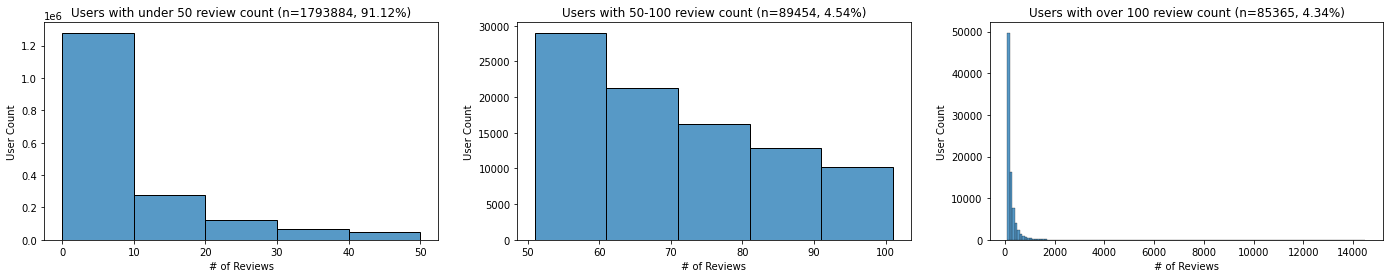

In [216]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(24,4))
sns.histplot(smallReviewCount, binwidth=10, ax=ax1)
sns.histplot(medReviewCount, binwidth=10, ax=ax2)
sns.histplot(bigReviewCount, binwidth=100, ax=ax3)

ax1.set(title=f'Users with under {meduserThreshold} review count (n={len(smallReviewCount)}, {smallReviewPercent}%)', xlabel='# of Reviews', ylabel='User Count')
ax2.set(title=f'Users with {meduserThreshold}-{superuserThreshold} review count (n={len(medReviewCount)}, {medReviewPercent}%)', xlabel='# of Reviews', ylabel='User Count')
ax3.set(title=f'Users with over {superuserThreshold} review count (n={len(bigReviewCount)}, {bigReviewPercent}%)', xlabel='# of Reviews', ylabel='User Count')
plt.show()

### `user.average_stars` Analysis: comparing Super users vs Normal users 
> Super users are denoted by a review count > 100

In [174]:
print(f" 'Normal users' avg stars: {  round(dfUsers.loc[dfUsers['review_count'] <= superuserThreshold]['average_stars'].mean(),2)  }")
print(f" 'Super users' avg stars: {   round(dfUsers.loc[dfUsers['review_count'] > superuserThreshold]['average_stars'].mean(),2)  }")

 'Normal users' avg stars: 3.64
 'Super users' avg stars: 3.81


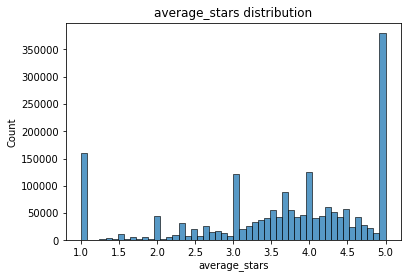

In [194]:
sns.histplot(dfUsers['average_stars'], bins=50).set(title='average_stars distribution')
plt.show()

### Users ordered by Review Count 
> By definition top and bottom 3, are super and normal users

In [184]:
dfUsers_sortedby_reviewCount = dfUsers.sort_values(by=['review_count'], ascending=False)
topUsers = dfUsers_sortedby_reviewCount.head(3)
bottomUsers = dfUsers_sortedby_reviewCount.tail(3)

display(topUsers, bottomUsers)

,user_id,name,review_count,yelping_since,useful,funny,elite,friends,fans,average_stars
416,8k3aO-mPeyhbR5HUucA5aA,Victor,14455,2007-12-08 14:56:45,101960,62685,"2008,2009,2010,2011,2012,2013,2014,2015,2016,2...","G2S8uIPRkyFNSs5os0hybA, y5HZivYR6HDOBwSDlddx6A...",1271,3.28
14169,RtGqdDBvvBCjcu5dUqwfzA,Shila,12772,2010-10-17 06:35:06,10508,3568,"2012,2013,2014,2015,2016,2017,2018","hz79Mq7EGhHXZkIspAQtrg, HuBgs7uHyUz7DzcaScZqjg...",285,3.87
635,hWDybu_KvYLSdEFzGrniTw,Bruce,12487,2009-03-08 21:47:44,108027,68719,"2010,2011,2012,2013,2014,2015,2016,2017,2018","OK-GE2QwR_D3qi5jrX8RsA, gjhzKWsqCIrpEd9pevbKZw...",659,3.64


,user_id,name,review_count,yelping_since,useful,funny,elite,friends,fans,average_stars
125809,AbbeFj9SPxOoHNKkeDVn6w,Janet,0,2017-07-11 06:37:38,0,2,,"fwwZK_bVBK-0ovQU8XCKBQ, etlj3-oBXWZDXFaF-684NA...",0,1.0
1474346,SoFv1NZbpnZdL051sVVXBA,Susanna,0,2017-09-16 21:26:12,0,0,,"588RSIeWljDTtZRcaGvB2w, vI2BFlKdFOpusSG4S0oEWg...",0,5.0
830420,0EoFWrwXLcY0HVmTqa13Bw,Amanda,0,2015-07-07 16:20:25,2,0,,"Vk7MRc1eBC9rWLYudTeueg, nO7l2G_dhnHmWeNHT-x0iA...",0,1.0


In [192]:
print( f"Top 100 users Avg stars: {round(dfUsers_sortedby_reviewCount.iloc[:100,:]['average_stars'].mean(),2)}")
print( f"Bottom 1,000 users Avg stars: {round(dfUsers_sortedby_reviewCount.iloc[-1000:,:]['average_stars'].mean(),2)}")

Top 100 users Avg stars: 3.73
Bottom 1,000 users Avg stars: 3.27


***
# Reviews json

# Data Pre-Processing: Review Text
---

## Problem Description:
- Bin and cluster average user rating to detect and remove "outlier" users that preferentially give the highest or lowest possible rating.
- Use the bag-of-words model to simplify review text (i.e. tokenize words, generate feature vectors for sentences).
- Model review text sentiment to classify reviews as either negative, positive or neutral

- Trendy foods, Time and Restaurant Category 

In [24]:
chunksize = 1000000
reviewReader = pd.read_json(filePaths['reviews'], lines=True,
                      dtype={'review_id':str,'user_id':str,
                             'business_id':str,'stars':int,
                             'date':str,'text':str,'useful':int,
                             'funny':int,'cool':int},
                      chunksize=chunksize)

## Todo: Pre-Process

***
## Merge json files: Reviews + Restaurants
> only combining reviews data relevant to businesses in our restaurants dataset
***

In [25]:
# Collect all df chunks 
chunk_list = []
for reviewChunk in reviewReader:
    reviewChunk = reviewChunk.drop(['review_id','useful','funny','cool'], axis=1)
    reviewChunk = reviewChunk.rename(columns={'stars': 'review_stars'})
    # Inner merge to obtain reviews for only restaurant
    chunk_merged = pd.merge(restaurantsTrimmed, reviewChunk, on='business_id', how='inner')
    # Show feedback on progress
    print(f"{chunk_merged.shape[0]} merged out of {chunksize:,} reviews")
    chunk_list.append(chunk_merged)

687736 merged out of 1,000,000 reviews
689432 merged out of 1,000,000 reviews
687518 merged out of 1,000,000 reviews
683562 merged out of 1,000,000 reviews
678753 merged out of 1,000,000 reviews
690264 merged out of 1,000,000 reviews
691960 merged out of 1,000,000 reviews
677194 merged out of 1,000,000 reviews
12134 merged out of 1,000,000 reviews


In [26]:
# concat all dataframe chunks into 1 dataframe
restaurants_reviews_df = pd.concat(chunk_list, ignore_index=True, axis=0)
restaurants_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5498553 entries, 0 to 5498552
Data columns (total 18 columns):
 #   Column        Dtype  
---  ------        -----  
 0   business_id   object 
 1   name          object 
 2   address       object 
 3   city          object 
 4   state         object 
 5   postal_code   object 
 6   latitude      float64
 7   longitude     float64
 8   stars         float64
 9   review_count  int64  
 10  is_open       int64  
 11  attributes    object 
 12  categories    object 
 13  hours         object 
 14  user_id       object 
 15  review_stars  int32  
 16  text          object 
 17  date          object 
dtypes: float64(3), int32(1), int64(2), object(12)
memory usage: 734.1+ MB


### City Distribution

In [203]:
restaurant_city = restaurants_reviews_df.city.value_counts().reset_index()
restaurant_city.columns = ['city', 'count']
restaurant_city.head(20)

,city,count
0,Las Vegas,1609318
1,Phoenix,550164
2,Toronto,483619
3,Scottsdale,294496
4,Charlotte,283581
5,Pittsburgh,212637
6,Henderson,156332
7,Tempe,153852
8,Montréal,150174
9,Mesa,120877


### Which cities have the best ```<category>``` ? 

In [27]:
pd.set_option('display.max_colwidth', 50)

In [28]:
restaurantsTrimmed.head()
# dfCities = restaurantsTrimmed[[]]

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
8,pQeaRpvuhoEqudo3uymHIQ,The Empanadas House,404 E Green St,Champaign,IL,61820,40.110446,-88.233073,4.5,5,1,"{'RestaurantsAttire': 'u'casual'', 'Restaurant...","Ethnic Food, Food Trucks, Specialty Food, Impo...","{'Monday': '11:30-14:30', 'Tuesday': '11:30-14..."
12,M_guz7Dj7hX0evS672wIwA,Chocolate Shoppe Ice Cream,2831 Parmenter St,Middleton,WI,53562,43.105310,-89.510142,3.5,6,1,"{'BikeParking': 'True', 'Caters': 'True', 'Whe...","Desserts, Food, Ice Cream & Frozen Yogurt","{'Monday': '0:0-0:0', 'Tuesday': '11:0-21:0', ..."
20,CsLQLiRoafpJPJSkNX2h5Q,Middle East Deli,4508 E Independence Blvd,Charlotte,NC,28205,35.194894,-80.767442,3.0,5,0,"{'RestaurantsGoodForGroups': 'True', 'OutdoorS...","Food, Restaurants, Grocery, Middle Eastern",None
23,mKTq1T_IAplDpHUcMzOXkw,Tipsy Ryde,,Gastonia,NC,28054,35.252842,-81.152698,3.5,3,1,{'BusinessAcceptsCreditCards': 'True'},"Hotels & Travel, Transportation, Taxis, Beer, ...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-0:0', 'W..."
24,eBEfgOPG7pvFhb2wcG9I7w,Philthy Phillys,"15480 Bayview Avenue, unit D0110",Aurora,ON,L4G 7J1,44.010962,-79.448677,4.5,4,1,"{'RestaurantsTableService': 'False', 'Restaura...","Restaurants, Cheesesteaks, Poutineries","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."


# Reviews: Text Features

## Todo: Data integration

> Compile all .json files into a relational database to improve accessibility.
